## Module 5: Analyse, diagnose and improve a model​

In the excercise of this week you will be working with financial data in order to (hopefully) find a portfolio of equities which outperform SP500. The data that you are gonna work with has two main sources: 
* Financial data from the companies extracted from the quarterly company reports (mostly extracted from [macrotrends](https://www.macrotrends.net/) so you can use this website to understand better the data and get insights on the features, for example [this](https://www.macrotrends.net/stocks/charts/AAPL/apple/revenue) is the one corresponding to APPLE)
* Stock prices, mostly extracted from [morningstar](https://indexes.morningstar.com/page/morningstar-indexes-empowering-investor-success?utm_source=google&utm_medium=cpc&utm_campaign=MORNI%3AG%3ASearch%3ABrand%3ACore%3AUK%20MORNI%3ABrand%3ACore%3ABroad&utm_content=engine%3Agoogle%7Ccampaignid%3A18471962329%7Cadid%3A625249340069&utm_term=morningstar%20index&gclid=CjwKCAjws9ipBhB1EiwAccEi1Fu6i20XHVcxFxuSEtJGF0If-kq5-uKnZ3rov3eRkXXFfI5j8QBtBBoCayEQAvD_BwE), which basically tell us how the stock price is evolving so we can use it both as past features and the target to predict).

Before going to the problem that we want to solve, let's comment some of the columns of the dataset:


* `Ticker`: a [short name](https://en.wikipedia.org/wiki/Ticker_symbol) to identify the equity (that you can use to search in macrotrends)
* `date`: the date of the company report (normally we are gonna have 1 every quarter). This is for informative purposes but you can ignore it when modeling.
* `execution date`: the date when we would had executed the algorithm for that equity. We want to execute the algorithm once per quarter to create the portfolio, but the release `date`s of all the different company reports don't always match for the quarter, so we just take a common `execution_date` for all of them.
* `stock_change_div_365`: what is the % change of the stock price (with dividens) in the FOLLOWING year after `execution date`. 
* `sp500_change_365`: what is the % change of the SP500 in the FOLLOWING year after `execution date`.
* `close_0`: what is the price at the moment of `execution date`
* `stock_change__minus_120` what is the % change of the stock price in the last 120 days
* `stock_change__minus_730`: what is the % change of the stock price in the last 730 days

The rest of the features can be divided beteween financial features (the ones coming from the reports) and technical features (coming from the stock price). We leave the technical features here as a reference: 

In [7]:
technical_features = ['close_0', 'close_sp500_0', 'close_365', 'close_sp500_365',
       'close__minus_120', 'close_sp500__minus_120', 'close__minus_365',
       'close_sp500__minus_365', 'close__minus_730', 'close_sp500__minus_730',
       'stock_change_365','stock_change_div_365', 'sp500_change_365', 'stock_change__minus_120',
       'sp500_change__minus_120', 'stock_change__minus_365',
       'sp500_change__minus_365', 'stock_change__minus_730','sp500_change__minus_730',
       'std__minus_365','std__minus_730','std__minus_120']

The problem that we want to solve is basically find a portfolio of `top_n` tickers (initially set to 10) to invest every `execution date` (basically once per quarter) and the goal is to have a better return than `SP500` in the following year. The initial way to model this is to have a binary target which is 1 when `stock_change_div_365` - `sp500_change_365` (the difference between the return of the equity and the SP500 in the following year) is positive or 0 otherwise. So we try to predict the probability of an equity of improving SP500 in the following year, we take the `top_n` equities and compute their final return.

In [8]:
import pandas as pd
import re
import numpy as np
import lightgbm as lgb
from plotnine import ggplot, geom_histogram, aes, geom_col, coord_flip,geom_bar,scale_x_discrete, geom_point, theme,element_text

In [9]:
# number of trees in lightgbm
n_trees = 40
minimum_number_of_tickers = 1500
# Number of the quarters in the past to train
n_train_quarters = 36
# number of tickers to make the portfolio
top_n = 10

In [10]:
data_set = pd.read_feather("../data/financials_against_return.feather")

Remove these quarters which have les than `minimum_number_of_tickers` tickers:

In [11]:
df_quarter_lengths = data_set.groupby(["execution_date"]).size().reset_index().rename(columns = {0:"count"})
data_set = pd.merge(data_set, df_quarter_lengths, on = ["execution_date"])
data_set = data_set[data_set["count"]>=minimum_number_of_tickers]

In [12]:
data_set.shape

(170483, 145)

Create the target:

In [13]:
data_set["diff_ch_sp500"] = data_set["stock_change_div_365"] - data_set["sp500_change_365"]

data_set.loc[data_set["diff_ch_sp500"]>0,"target"] = 1
data_set.loc[data_set["diff_ch_sp500"]<0,"target"] = 0

data_set["target"].value_counts()

target
0.0    82437
1.0    73829
Name: count, dtype: int64

---

This function computes the main metric that we want to optimize: given a prediction where we have probabilities for each equity, we sort the equities in descending order of probability, we pick the `top_n` ones, and we weight the returned `diff_ch_sp500` by the probability:

In [14]:
def get_weighted_performance_of_stocks(df,metric):
    df["norm_prob"] = 1/len(df)
    return np.sum(df["norm_prob"]*df[metric])

def get_top_tickers_per_prob(preds):
    if len(preds) == len(train_set):
        data_set = train_set.copy()
    elif len(preds) == len(test_set):
        data_set = test_set.copy()
    else:
        assert ("Not matching train/test")
    data_set["prob"] = preds
    data_set = data_set.sort_values(["prob"], ascending = False)
    data_set = data_set.head(top_n)
    return data_set

# main metric to evaluate: average diff_ch_sp500 of the top_n stocks
def top_wt_performance(preds, train_data):
    top_dataset = get_top_tickers_per_prob(preds)
    return "weighted-return", get_weighted_performance_of_stocks(top_dataset,"diff_ch_sp500"), True

We have created for you a function to make the `train` and `test` split based on a `execution_date`:

In [15]:
def split_train_test_by_period(data_set, test_execution_date,include_nulls_in_test = False):
    # we train with everything happening at least one year before the test execution date
    train_set = data_set.loc[data_set["execution_date"] <= pd.to_datetime(test_execution_date) - pd.Timedelta(350, unit = "day")]
    # remove those rows where the target is null
    train_set = train_set[~pd.isna(train_set["diff_ch_sp500"])]
    execution_dates = train_set.sort_values("execution_date")["execution_date"].unique()
    # Pick only the last n_train_quarters
    if n_train_quarters!=None:
        train_set = train_set[train_set["execution_date"].isin(execution_dates[-n_train_quarters:])]
        
    # the test set are the rows happening in the execution date with the concrete frequency
    test_set = data_set.loc[(data_set["execution_date"] == test_execution_date)]
    if not include_nulls_in_test:
        test_set = test_set[~pd.isna(test_set["diff_ch_sp500"])]
    test_set = test_set.sort_values('date', ascending = False).drop_duplicates('Ticker', keep = 'first')
    
    return train_set, test_set

Ensure that we don't include features which are irrelevant or related to the target:

In [16]:
def get_columns_to_remove():
    columns_to_remove = [
                         "date",
                         "improve_sp500",
                         "Ticker",
                         "freq",
                         "set",
                         "close_sp500_365",
                         "close_365",
                         "stock_change_365",
                         "sp500_change_365",
                         "stock_change_div_365",
                         "stock_change_730",
                         "sp500_change_365",
                         "stock_change_div_730",
                         "diff_ch_sp500",
                         "diff_ch_avg_500",
                         "execution_date","target","index","quarter","std_730","count"]
        
    return columns_to_remove

This is the main modeling function, it receives a train set and a test set and trains a `lightgbm` in classification mode. We don't recommend to change the main algorithm for this excercise but we suggest to play with its hyperparameters:

In [43]:
import warnings
warnings.filterwarnings('ignore')


def train_model(train_set,test_set,n_estimators = 300, remove_more_columns = False):

    if remove_more_columns:
        print("Removing additional columns due to high null percentage")
        columns_to_remove = get_columns_to_remove() + remove_more_columns
    else:
        columns_to_remove = get_columns_to_remove()

    X_train = train_set.drop(columns = columns_to_remove, errors = "ignore")
    X_test = test_set.drop(columns = columns_to_remove, errors = "ignore")
    
    
    y_train = train_set["target"]
    y_test = test_set["target"]

    lgb_train = lgb.Dataset(X_train,y_train)
    lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)
    
    eval_result = {}
    
 
    objective = 'binary'
    metric = 'binary_logloss' 
    params = {
             "random_state":1, 
             "verbosity": -1,
             "n_jobs":10, 
             "n_estimators":n_estimators,
             "objective": objective,
             "metric": metric}
    
    model = lgb.train(params = params,train_set = lgb_train,
                      valid_sets = [lgb_test,lgb_train],
                      feval = [top_wt_performance],
                      callbacks = [lgb.record_evaluation(eval_result = eval_result)])
    return model,eval_result,X_train,X_test


 
            

This is the function which receives an `execution_date` and splits the dataset between train and test, trains the models and evaluates the model in test. It returns a dictionary with the different evaluation metrics in train and test:

In [44]:
def run_model_for_execution_date(execution_date,all_results,all_predicted_tickers_list,all_models,n_estimators,include_nulls_in_test = False, remove_more_columns = False):
        global train_set
        global test_set
        # split the dataset between train and test
        train_set, test_set = split_train_test_by_period(data_set,execution_date,include_nulls_in_test = include_nulls_in_test)
        train_size, _ = train_set.shape
        test_size, _ = test_set.shape
        model = None
        X_train = None
        X_test = None
        
        # if both train and test are not empty
        if train_size > 0 and test_size>0:
            model, evals_result, X_train, X_test = train_model(train_set,
                                                              test_set,
                                                              n_estimators = n_estimators,
                                                              remove_more_columns = remove_more_columns)
            
            test_set['prob'] = model.predict(X_test)
            predicted_tickers = test_set.sort_values('prob', ascending = False)
            predicted_tickers["execution_date"] = execution_date
            all_results[(execution_date)] = evals_result
            all_models[(execution_date)] = model
            all_predicted_tickers_list.append(predicted_tickers)
        return all_results,all_predicted_tickers_list,all_models,model,X_train,X_test


execution_dates = np.sort( data_set['execution_date'].unique() )


This is the main training loop: it goes through each different `execution_date` and calls `run_model_for_execution_date`. All the results are stored in `all_results` and the predictions in `all_predicted_tickers_list`.

In [19]:
all_results = {}
all_predicted_tickers_list = []
all_models = {}

for execution_date in execution_dates:
    print(execution_date)
    all_results,all_predicted_tickers_list,all_models,model,X_train,X_test = run_model_for_execution_date(execution_date,all_results,all_predicted_tickers_list,all_models,n_trees,False)
all_predicted_tickers = pd.concat(all_predicted_tickers_list) 

2005-06-30T00:00:00.000000000
2005-09-30T00:00:00.000000000
2005-12-30T00:00:00.000000000
2006-03-31T00:00:00.000000000
2006-06-30T00:00:00.000000000
2006-09-30T00:00:00.000000000
2006-12-30T00:00:00.000000000
2007-03-31T00:00:00.000000000
2007-06-30T00:00:00.000000000
2007-09-30T00:00:00.000000000
2007-12-30T00:00:00.000000000
2008-03-31T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-09-30T00:00:00.000000000
2008-12-30T00:00:00.000000000
2009-03-31T00:00:00.000000000
2009-06-30T00:00:00.000000000
2009-09-30T00:00:00.000000000
2009-12-30T00:00:00.000000000
2010-03-31T00:00:00.000000000
2010-06-30T00:00:00.000000000
2010-09-30T00:00:00.000000000
2010-12-30T00:00:00.000000000
2011-03-31T00:00:00.000000000
2011-06-30T00:00:00.000000000
2011-09-30T00:00:00.000000000
2011-12-30T00:00:00.000000000
2012-03-31T00:00:00.000000000
2012-06-30T00:00:00.000000000
2012-09-30T00:00:00.000000000
2012-12-30T00:00:00.000000000
2013-03-31T00:00:00.000000000
2013-06-30T00:00:00.000000000
2013-09-30

In [20]:
def parse_results_into_df(set_):
    df = pd.DataFrame()
    for date in all_results:
        df_tmp = pd.DataFrame(all_results[(date)][set_])
        df_tmp["n_trees"] = list(range(len(df_tmp)))
        df_tmp["execution_date"] = date
        df= pd.concat([df,df_tmp])
    
    df["execution_date"] = df["execution_date"].astype(str)
    
    return df

In [21]:
test_results = parse_results_into_df("valid_0")
train_results = parse_results_into_df("training")

In [22]:
test_results_final_tree = test_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")
train_results_final_tree = train_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")


And this are the results:

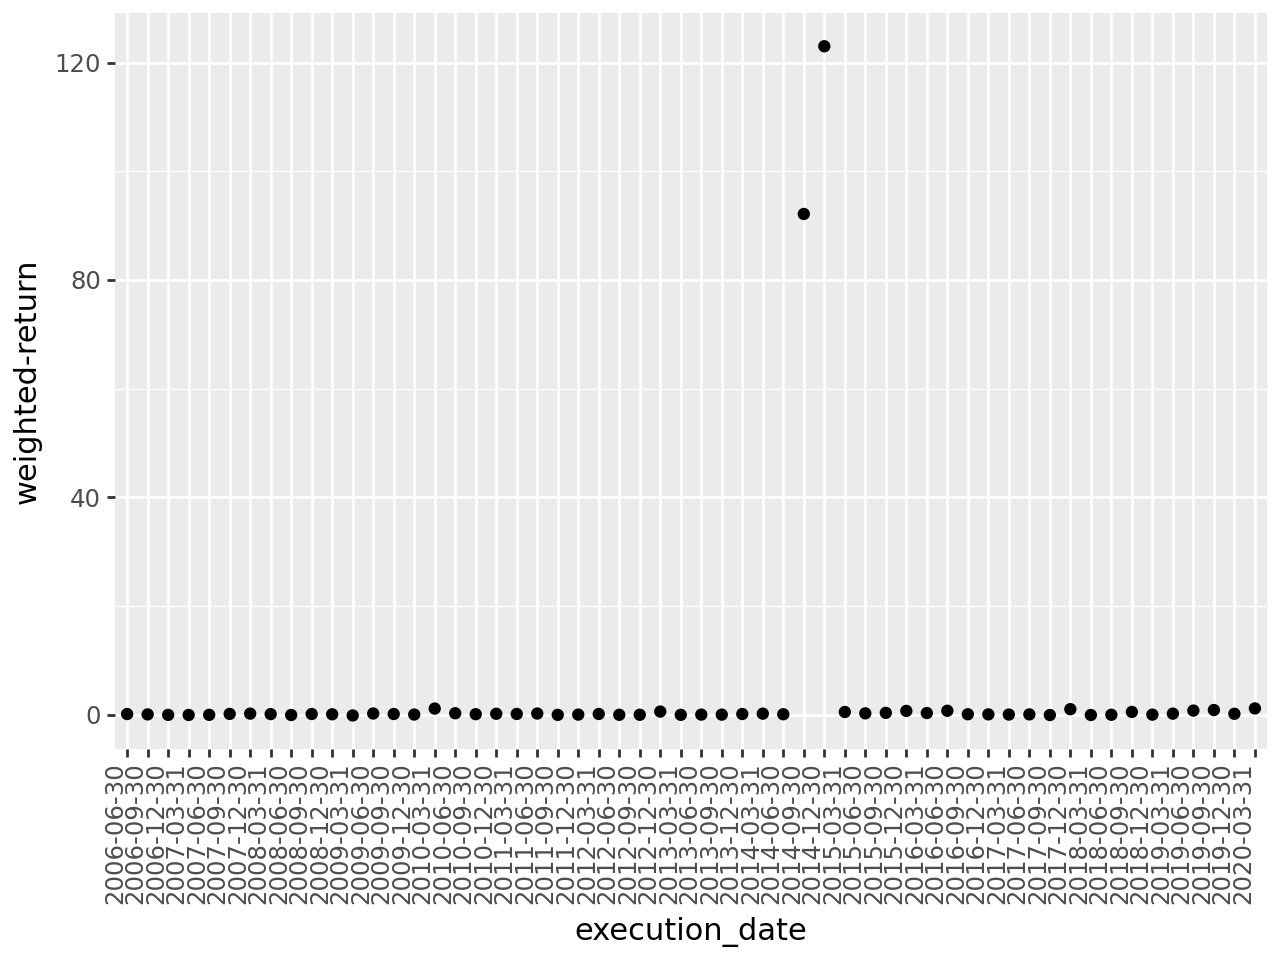

In [23]:
ggplot(test_results_final_tree) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))

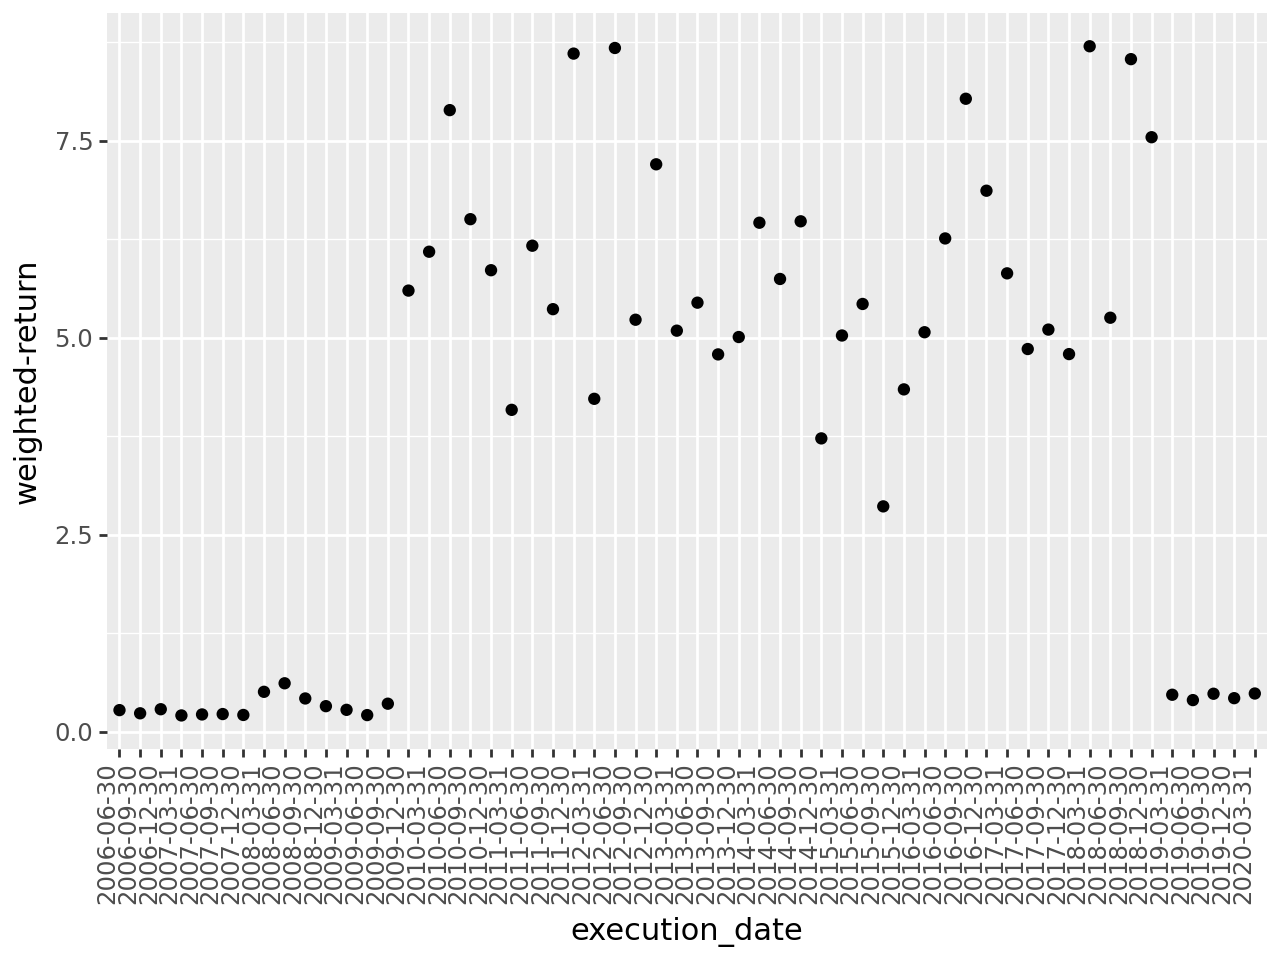

In [24]:
ggplot(train_results_final_tree) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))


We have trained the first models for all the periods for you, but there are a lot of things which may be wrong or can be improved. Some ideas where you can start:
* Try to see if there is any kind of data leakage or suspicious features
* If the training part is very slow, try to see how you can modify it to execute faster tests
* Try to understand if the algorithm is learning correctly
* We are using a very high level metric to evaluate the algorithm so you maybe need to use some more low level ones
* Try to see if there is overfitting
* Try to see if there is a lot of noise between different trainings
* To simplify, why if you only keep the first tickers in terms of Market Cap?
* Change the number of quarters to train in the past

This function can be useful to compute the feature importance:

In [25]:
def draw_feature_importance(model,top = 15):
    fi = model.feature_importance()
    fn = model.feature_name()
    feature_importance = pd.DataFrame([{"feature":fn[i],"imp":fi[i]} for i in range(len(fi))])
    feature_importance = feature_importance.sort_values("imp",ascending = False).head(top)
    feature_importance = feature_importance.sort_values("imp",ascending = True)
    plot = ggplot(feature_importance,aes(x = "feature",y  = "imp")) + geom_col(fill = "lightblue") + coord_flip() +  scale_x_discrete(limits = feature_importance["feature"])
    return plot, feature_importance


In [26]:
from scipy.stats import lognorm
import matplotlib.pyplot as plt

---
# **ANÁLISIS DEL MODELO**

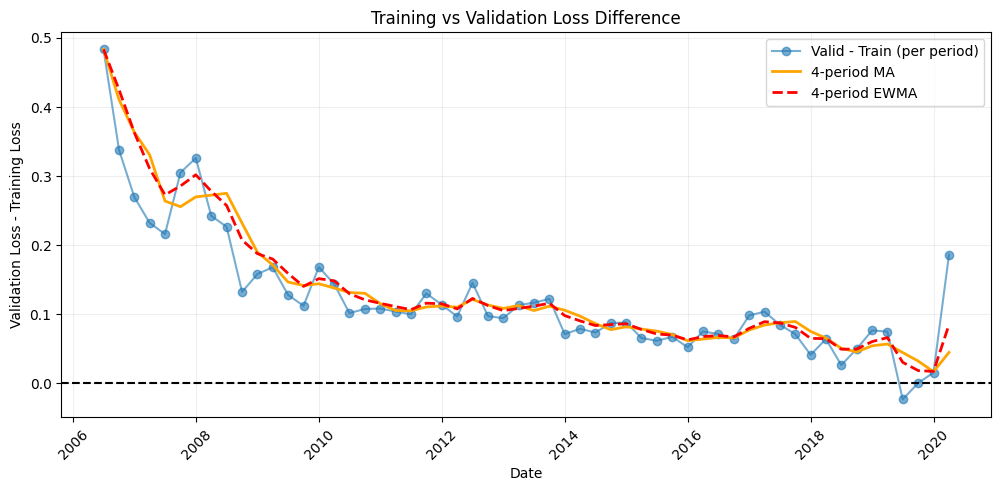

In [27]:
loss_diffs = []
datetimes = []

for date in all_results: 
    last_train_loss = all_results[date]['training']['binary_logloss'][-1]
    last_valid_loss = all_results[date]['valid_0']['binary_logloss'][-1] 
    loss_diffs.append(last_valid_loss - last_train_loss)
    datetimes.append(pd.to_datetime(date))

s = pd.Series(loss_diffs, index=pd.to_datetime(datetimes)).sort_index()

ma_window = 4  # 1-year moving averages 
s_ma = s.rolling(window=ma_window, min_periods=1).mean()
s_ewm = s.ewm(span=ma_window, adjust=False).mean()

plt.figure(figsize=(12,5))
plt.plot(s.index, s.values, marker='o', label='Valid - Train (per period)', alpha=0.6)
plt.plot(s_ma.index, s_ma.values, color='orange', linewidth=2, label=f'{ma_window}-period MA')
plt.plot(s_ewm.index, s_ewm.values, color='red', linewidth=2, linestyle='--', label=f'{ma_window}-period EWMA')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Validation Loss - Training Loss')
plt.title('Training vs Validation Loss Difference')
plt.legend()
plt.grid(alpha=0.2)
plt.xticks(rotation=45)
plt.show()

A medida que va pasando el tiempo, el modelo va mejorando su su capacidad de generalización (esto es, reduciendo el overfitting). En las últimas fechas ya empezaba a mostrar buenos resultados. Hay dos puntos en los que la tendencia de mejora se rompió: en 2008 y en 2020. Estos periodos probablemente coincidieron con las crisis producidas en ambos años (la crisis financiera y la crisis provocada por el COVID). Una hipótesis plausible es que los acontecimientos de dichas fechas provocaron que los datos estuviesen fuera de la distribución que venía rigiendo el fenómeno. 

In [28]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier


def adversarial_validation(date: np.datetime64, plot: bool = False) -> float:
    train_data, test_data = split_train_test_by_period(
        data_set, date, include_nulls_in_test=True
    )
    train_data['is_test'] = 0
    test_data['is_test'] = 1
    combined_data = pd.concat([train_data, test_data], ignore_index=True)
    combined_data = combined_data.sample(frac=1, random_state=42).reset_index(drop=True)

    X = combined_data.drop(
        columns=get_columns_to_remove() + ['is_test'], errors='ignore'
    )
    X = X.replace([np.inf, -np.inf], np.nan)
    y = combined_data['is_test']

    model = lgb.LGBMClassifier(
        n_estimators=1000, 
        learning_rate=0.05,
        num_leaves=63, 
        max_depth=-1, 
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1,
        objective='binary',
    )

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    aucs = []
    for train_index, val_index in skf.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        aucs.append(auc)
    
    return np.mean(aucs)


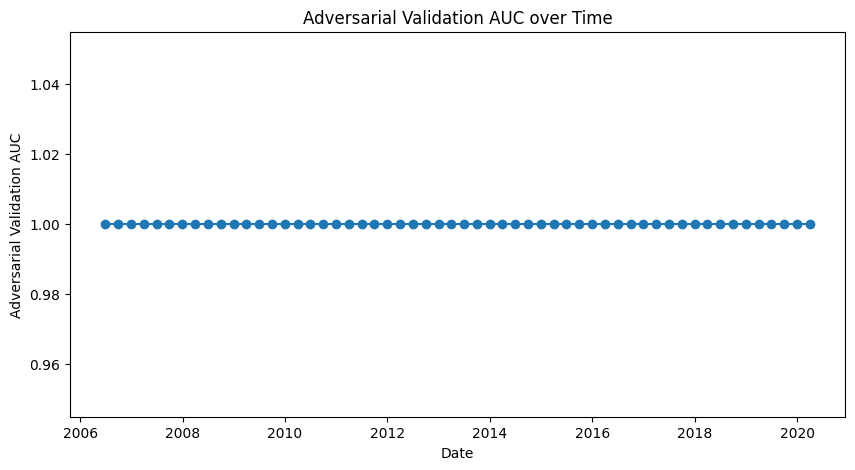

In [29]:
aucs = [] 

for date in all_models: 
    auc_score = adversarial_validation(date)
    aucs.append(auc_score)

plt.figure(figsize=(10,5))
plt.plot(datetimes, aucs, marker='o')
plt.xlabel('Date')
plt.ylabel('Adversarial Validation AUC')
plt.title('Adversarial Validation AUC over Time')
plt.show()

Las pruebas de validación adversaria muestran que los datos de entrenamiento y validación para todos los `execution_dates` provienen de diferentes distribuciones. Esto podría explicar que el modelo tenga poca capacidad de generalización durante las primeras versiones del modelo. Sin embargo, antes hemos visto que se va reduciendo el gap entre entrenamiento y validación conforme se va iterando con nuevos datos, cosa que en teoría debería ser porque train y val vienen de la misma distribución. Sin embargo, la validación adversaria muestra que ambos conjuntos siguen viniendo de distribuciones diferentes. 

A continuación, nos centraremos en el penúltimo modelo de la lista `all_models`, pues el último se correspondería con el de marzo de 2020. En esta fecha se produjo un evento de cisne negro (COVID) que pudo alterar la distribución de los datos, por lo que sería totalmente comprensible que el modelo no funcionase bien. Para evitar realizar el análisis en una situación así, analizaremos el modelo inmediatamente anterior. 

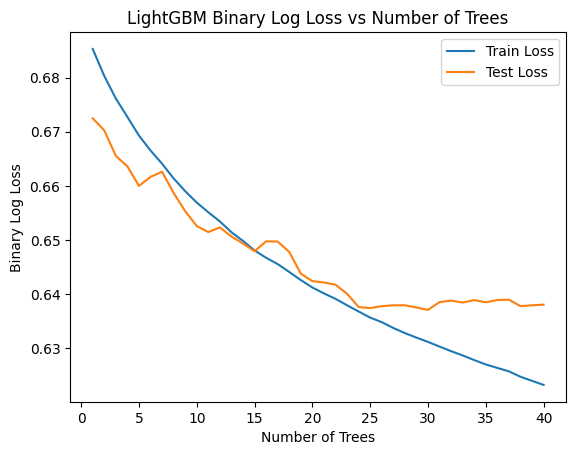

In [30]:
date = list(all_results.keys())[-2]

num_trees = list(range(1, len(all_results[date]['training']['binary_logloss']) + 1))

train_loss = np.array(all_results[date]['training']['binary_logloss'])
test_loss = np.array(all_results[date]['valid_0']['binary_logloss'])

plt.plot(num_trees, train_loss, label='Train Loss')
plt.plot(num_trees, test_loss, label='Test Loss')
plt.xlabel('Number of Trees')
plt.ylabel('Binary Log Loss')
plt.title('LightGBM Binary Log Loss vs Number of Trees')
plt.legend()
plt.show()

Las curvas de entrenamiento y validación parecen comportarse según lo esperado. La curva de train va bajando de forma suave, y la de validación llega un punto en el que se estanca. A priori, parece que el modelo está aprendiendo. 

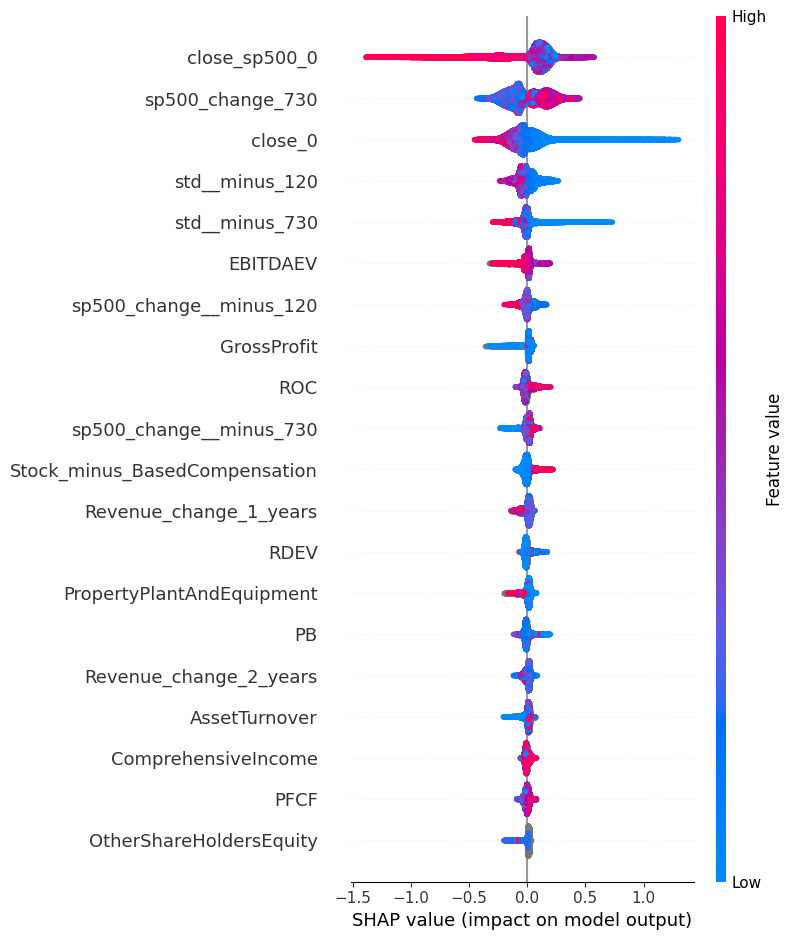

In [31]:
from shap import TreeExplainer, summary_plot

test_model = all_models[list(all_models.keys())[-1]]
explainer = TreeExplainer(test_model)
train_set, test_set = split_train_test_by_period(
    data_set, list(all_models.keys())[-1], include_nulls_in_test=True
)
X_train = train_set.drop(
    columns=get_columns_to_remove(), errors='ignore'
)
shap_values = explainer.shap_values(X_train)
summary_plot(shap_values, X_train)

De las variables con mayor impacto, se puede destacar:  

- **`close_sp500_0`**: Cuanto mayor es el precio de cierre del índice, menor es la probabilidad de que la acción lo supere. Esto parece lógico, pues es más difícil superar el índice si este cotiza muy alto. 
- **`sp_change_730`**: Si el índice ha tenido una rentabilidad positiva con respecto a dos años antes, el modelo considera más probable que la acción bata al índice (y viceversa). El efecto no es muy exagerado, pero es una de las variables más importantes para el modelo. 
- **`close_0`**: Cuanto menor es el precio de cierre de la acción, el modelo empuja hacia arriba la probabilidad de superar al índice. Esto podría ser debido a que el modelo interpreta que hay alguna relación entre una baja cotización y subidas muy altas en bolsa. A priori parece extraño, convendría investigarlo, pues es una variable crucial para el modelo. 
- **`std_minus_730`**: Una menor volatilidad de la acción en los últimos 2 años hace que sea más probable que la acción supere al índice. Desde la perspectiva del análisis técnico, un periodo largo de baja volatilidad y movimiento lateral hace que se 'acumule energía' que luego se liberará en un tramo al alza o a la baja. Una posible hipótesis es que el modelo está siendo víctima del sesgo del superviviente, y ha visto ejemplos de acciones que han experimentado un movimiento lateral seguido de un tramo al alza, pero las empresas que fracasaron (movimeinto lateral + caída) no se encuentran reistradas. Esto haría que el modelo únicamente haya visto casos exitosos, por lo que habría encontrado un patrón claro entre baja volatilidad reciente y movimientos al alza que suponen un sorpaso al índice. De ser esto cierto, supondría un problema, pues el modelo habría aprendido un patrón que no tiene por qué ser cierto, y podría ser una de las causas por las que el modelo no está funcionando bien. 

Para predecir si la cotización de una determinada empresa superará la rentabilidad del S&P500, el modelo se fija mayoritariamente en variables que dan información sobre el estado de la bolsa, en vez del estado de la empresa como tal. Se fija principalmente en el precio de cierre en `execution_date` del S&P500 y su rentabilidad en los últimos dos años, así como en el precio de cierre de la acción y de su volatilidad durante los últimos dos años. Es decir, el modelo no está realizando un análisis fundamental de la empresa, sino que se está fijando en valores del mercado. Pese a que estos datos del estado de la bolsa pueden ser perfectamente útiles, no tiene mucho sentido que el modelo no use los datos de los informes, pues a un inversor humano es algo que le aporta mucho valor. Una pregunta que surge de aquí es: **¿por qué el modelo desestima la información de los quarter reports?** 

Para tratar de determinar si la información de los quarter reports es significativa, se va a entrenar una versión del modelo en el que únicamente se utilizan las 5 variables más importantes según SHAP. Si el rendimiento del modelo es muy similar, se puede concluir que las variables de los reports no están teniendo impacto. 

In [32]:
columns_to_use_reduced = X_train.columns[np.argsort(np.abs(shap_values).mean(0))[::-1][:5]]
last_date = list(all_models.keys())[-2]
columns_to_use = list(columns_to_use_reduced)

if "target" not in data_set.columns:
    data_set["diff_ch_sp500"] = data_set["stock_change_div_365"] - data_set["sp500_change_365"]
    data_set.loc[data_set["diff_ch_sp500"] > 0, "target"] = 1
    data_set.loc[data_set["diff_ch_sp500"] < 0, "target"] = 0

def train_model_with_columns(train_set, test_set, selected_cols, n_estimators=300):
    cols_remove = get_columns_to_remove() 
    X_train_full = train_set.drop(columns=cols_remove, errors="ignore")
    X_test_full  = test_set.drop(columns=cols_remove, errors="ignore")

    valid_cols = [c for c in selected_cols if c in X_train_full.columns]
    if len(valid_cols) == 0:
        raise ValueError("Ninguna de las columnas solicitadas está en el train tras filtrar.")
    X_train = X_train_full[valid_cols]
    X_test  = X_test_full[valid_cols]

    y_train = train_set["target"]
    y_test  = test_set["target"]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_test  = lgb.Dataset(X_test,  y_test, reference=lgb_train)

    eval_result = {}
    params = {
        "random_state": 1,
        "verbosity": -1,
        "n_jobs": 10,
        "n_estimators": n_estimators,
        "objective": "binary",
        "metric": "binary_logloss",
    }

    model = lgb.train(
        params=params,
        train_set=lgb_train,
        valid_sets=[lgb_test, lgb_train],
        feval=[top_wt_performance],
        callbacks=[lgb.record_evaluation(eval_result=eval_result)],
    )
    return model, eval_result, X_train, X_test

def run_model_for_date_with_columns(execution_date, selected_cols, n_estimators=300, include_nulls_in_test=False):
    global train_set, test_set
    train_set, test_set = split_train_test_by_period(
        data_set, execution_date, include_nulls_in_test=include_nulls_in_test
    )

    if (len(train_set) == 0) or (len(test_set) == 0):
        raise ValueError("Train o test vacíos para esa execution_date.")

    model, evals_result, X_train, X_test = train_model_with_columns(
        train_set, test_set, selected_cols, n_estimators=n_estimators
    )

    test_set = test_set.copy()
    test_set["prob"] = model.predict(X_test)
    predicted_tickers = test_set.sort_values("prob", ascending=False)
    return model, evals_result, X_train, X_test, predicted_tickers

model_sel, evals_sel, Xtr_sel, Xte_sel, pred_tickers_sel = run_model_for_date_with_columns(
    last_date, columns_to_use, n_estimators=n_trees
)

columns_to_remove = get_columns_to_remove()
columns_to_use_full = [c for c in data_set.columns if c not in columns_to_remove]
model_full, evals_full, Xtr_full, Xte_full, pred_tickers_full = run_model_for_date_with_columns(
    last_date, columns_to_use_full, n_estimators=n_trees
)

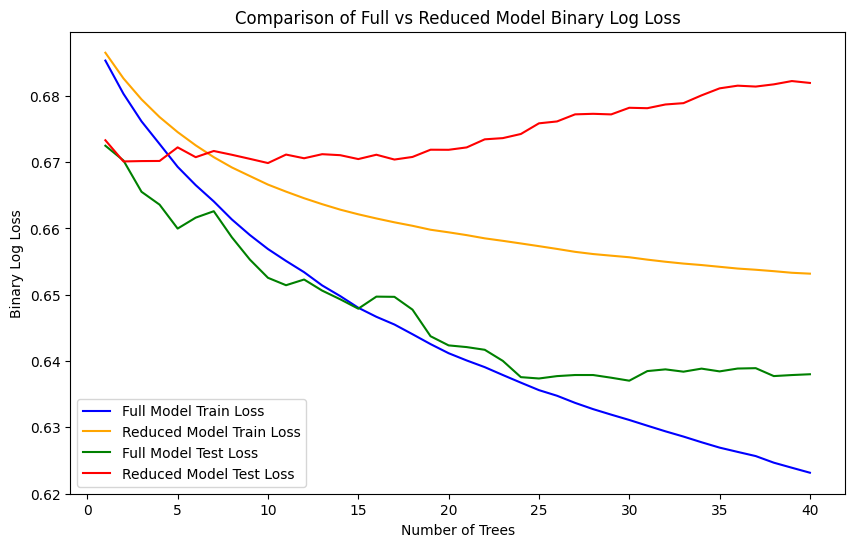

In [33]:
full_train_loss = np.array(evals_full['training']['binary_logloss'])
sel_train_loss = np.array(evals_sel['training']['binary_logloss'])

full_test_loss = np.array(evals_full['valid_0']['binary_logloss'])
sel_test_loss = np.array(evals_sel['valid_0']['binary_logloss'])

num_trees = list(range(1, len(full_train_loss) + 1))

plt.figure(figsize=(10, 6))
plt.plot(num_trees, full_train_loss, label='Full Model Train Loss', color='blue')
plt.plot(num_trees, sel_train_loss, label='Reduced Model Train Loss', color='orange')
plt.plot(num_trees, full_test_loss, label='Full Model Test Loss', color='green')
plt.plot(num_trees, sel_test_loss, label='Reduced Model Test Loss', color='red')
plt.xlabel('Number of Trees')
plt.ylabel('Binary Log Loss')
plt.title('Comparison of Full vs Reduced Model Binary Log Loss')
plt.legend()
plt.show()

Las diferencias en las métricas de pérdida son poco significativas (del orden de 0.05), por lo que el modelo reducido obtiene prácticamente los mismos resultados que el modelo original. Esto refuerza la teoría de que solo está usando las variables mencionadas unas celdas atrás. 

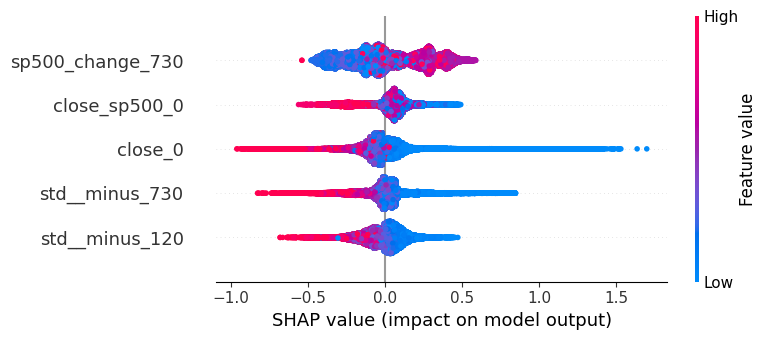

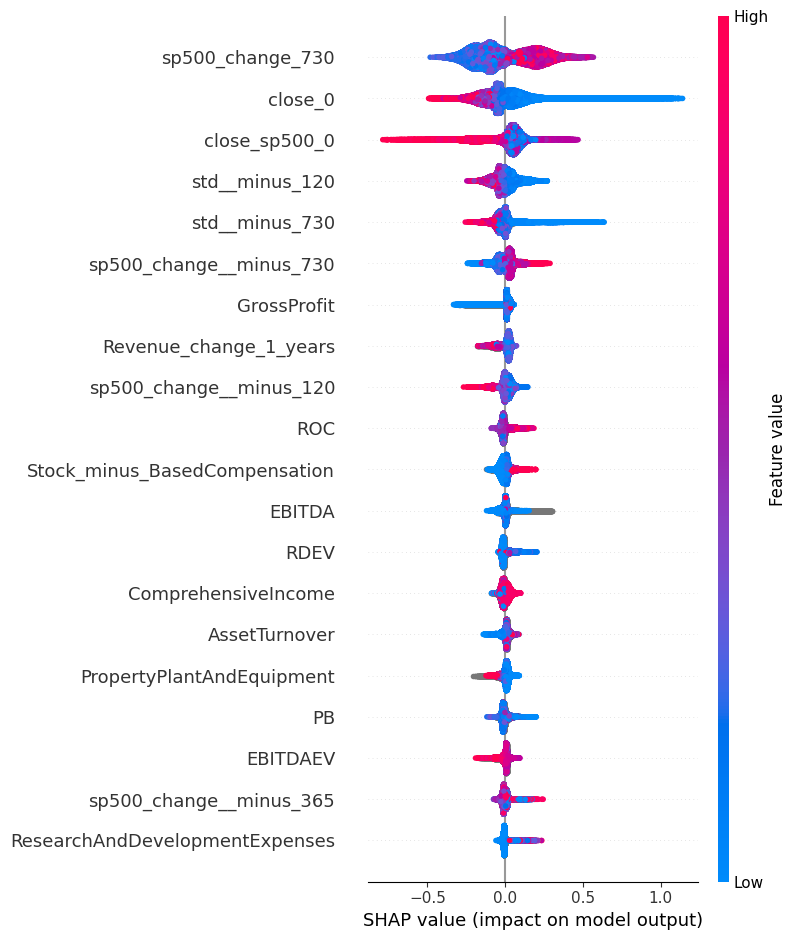

In [34]:
reduced_explainer = TreeExplainer(model_sel)
reduced_shap_values = reduced_explainer.shap_values(Xtr_sel)
summary_plot(reduced_shap_values, Xtr_sel)

full_explainer = TreeExplainer(model_full)
full_shap_values = full_explainer.shap_values(Xtr_full)
summary_plot(full_shap_values, Xtr_full)

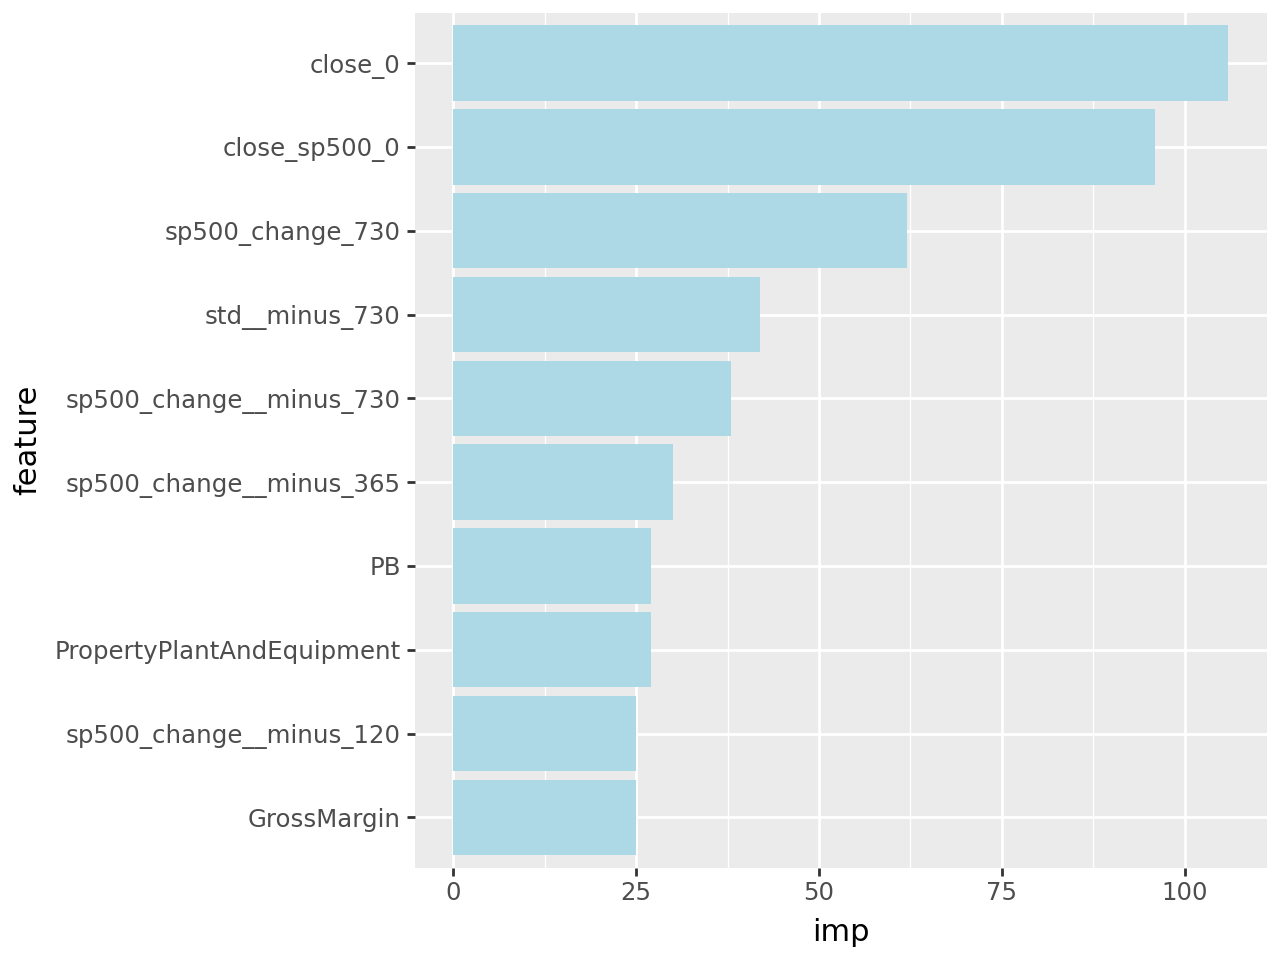

In [35]:
plot_full, fi_full = draw_feature_importance(model_full, top=10)
plot_reduced, fi_reduced = draw_feature_importance(model_sel, top=10)

plot_full

La importancia de las variables en ambos modelos es casi igual. Con estas pruebas, se puede concluir que el modelo no está empleando la información disponible de en los quarter reports. 

De momento, los hallazgos se pueden resumir en: 

- El modelo ha encontrado una relación inversa entre el precio de cierre de la acción y la probabilidad de que supere al S&P500 en un año. 
- El modelo ha encontrado una relación inversa entre el precio de cierre del S&P500 y la probabilidad de que la acción supere al índice. 
- El modelo no está usando la información de los quarter reports. 

Para tratar de averiguar por qué el modelo está exhibiendo este comportamiento, se debería contar con un cierto nivel de conocimiento de negocio o, en su defecto, disponer de un canal de comunicación con la parte de negocio para poder responder a estas cuestiones. 

In [36]:
nulls_in_dataset = data_set.isnull().sum()
nulls_percentage = (nulls_in_dataset / len(data_set)) * 100
nulls_percentage = dict(sorted(nulls_percentage.items(), key=lambda item: item[1], reverse=False))
for col, perc in nulls_percentage.items():
    print(f"{col} -> {perc:.2f}%")

Ticker -> 0.00%
date -> 0.00%
NetIncomeLoss -> 0.00%
execution_date -> 0.00%
close_0 -> 0.00%
close_sp500_0 -> 0.00%
sp500_change__minus_120 -> 0.00%
sp500_change__minus_365 -> 0.00%
sp500_change__minus_730 -> 0.00%
Market_cap -> 0.00%
n_finan_prev_year -> 0.00%
PE -> 0.00%
count -> 0.00%
NetCashFlow -> 0.05%
PFCF -> 0.09%
std__minus_120 -> 0.15%
std__minus_365 -> 0.15%
std__minus_730 -> 0.15%
TotalAssets -> 0.18%
CashFlowFromOperatingActivities -> 0.71%
NetIncome -> 1.04%
TotalLiabilitiesAndShareHoldersEquity -> 1.08%
Pre_minus_TaxIncome -> 1.10%
ShareHolderEquity -> 1.11%
OperatingIncome -> 1.12%
CashFlowFromInvestingActivities -> 1.13%
stock_change__minus_120 -> 1.14%
stock_change_div__minus_120 -> 1.14%
CashFlowFromFinancialActivities -> 1.14%
TotalLiabilities -> 1.16%
IncomeFromContinuousOperations -> 1.17%
IncomeAfterTaxes -> 1.27%
TotalChangeInAssetsLiabilities -> 1.43%
TotalCurrentAssets -> 1.43%
TotalNon_minus_CashItems -> 1.48%
TotalDepreciationAndAmortization_minus_CashFlow 

Se observa que hay una gran cantidad de variables sacadas de los quarter reports con una gran cantidad de valores nulos. LightGBM maneja internamente los nulos, pero tener tantos valores faltantes puede hacer que la variable no sea informativa, de ahí que el modelo decida no usarla. Para comprobar si hay mejora, se eliminarán variables con muchos nulos y se reentrenará el modelo. 

In [49]:
all_results_reduced = {}
all_predicted_tickers_list_reduced = []
all_models_reduced = {}

new_columns_to_remove = [col for col, perc in nulls_percentage.items() if perc > 15 and col not in get_columns_to_remove()]

for execution_date in execution_dates:
    print(execution_date)
    all_results_reduced,all_predicted_tickers_list_reduced,all_models_reduced,model,X_train,X_test = run_model_for_execution_date(execution_date,all_results_reduced,
                                                                                                                                  all_predicted_tickers_list_reduced,
                                                                                                                                  all_models_reduced,n_trees,False,
                                                                                                                                    remove_more_columns = new_columns_to_remove)
all_predicted_tickers = pd.concat(all_predicted_tickers_list_reduced) 

2005-06-30T00:00:00.000000000
2005-09-30T00:00:00.000000000
2005-12-30T00:00:00.000000000
2006-03-31T00:00:00.000000000
2006-06-30T00:00:00.000000000
Removing additional columns due to high null percentage
2006-09-30T00:00:00.000000000
Removing additional columns due to high null percentage
2006-12-30T00:00:00.000000000
Removing additional columns due to high null percentage
2007-03-31T00:00:00.000000000
Removing additional columns due to high null percentage
2007-06-30T00:00:00.000000000
Removing additional columns due to high null percentage
2007-09-30T00:00:00.000000000
Removing additional columns due to high null percentage
2007-12-30T00:00:00.000000000
Removing additional columns due to high null percentage
2008-03-31T00:00:00.000000000
Removing additional columns due to high null percentage
2008-06-30T00:00:00.000000000
Removing additional columns due to high null percentage
2008-09-30T00:00:00.000000000
Removing additional columns due to high null percentage
2008-12-30T00:00:00.

In [50]:
test_results = parse_results_into_df("valid_0")
train_results = parse_results_into_df("training")

test_results_final_tree = test_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")
train_results_final_tree = train_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")

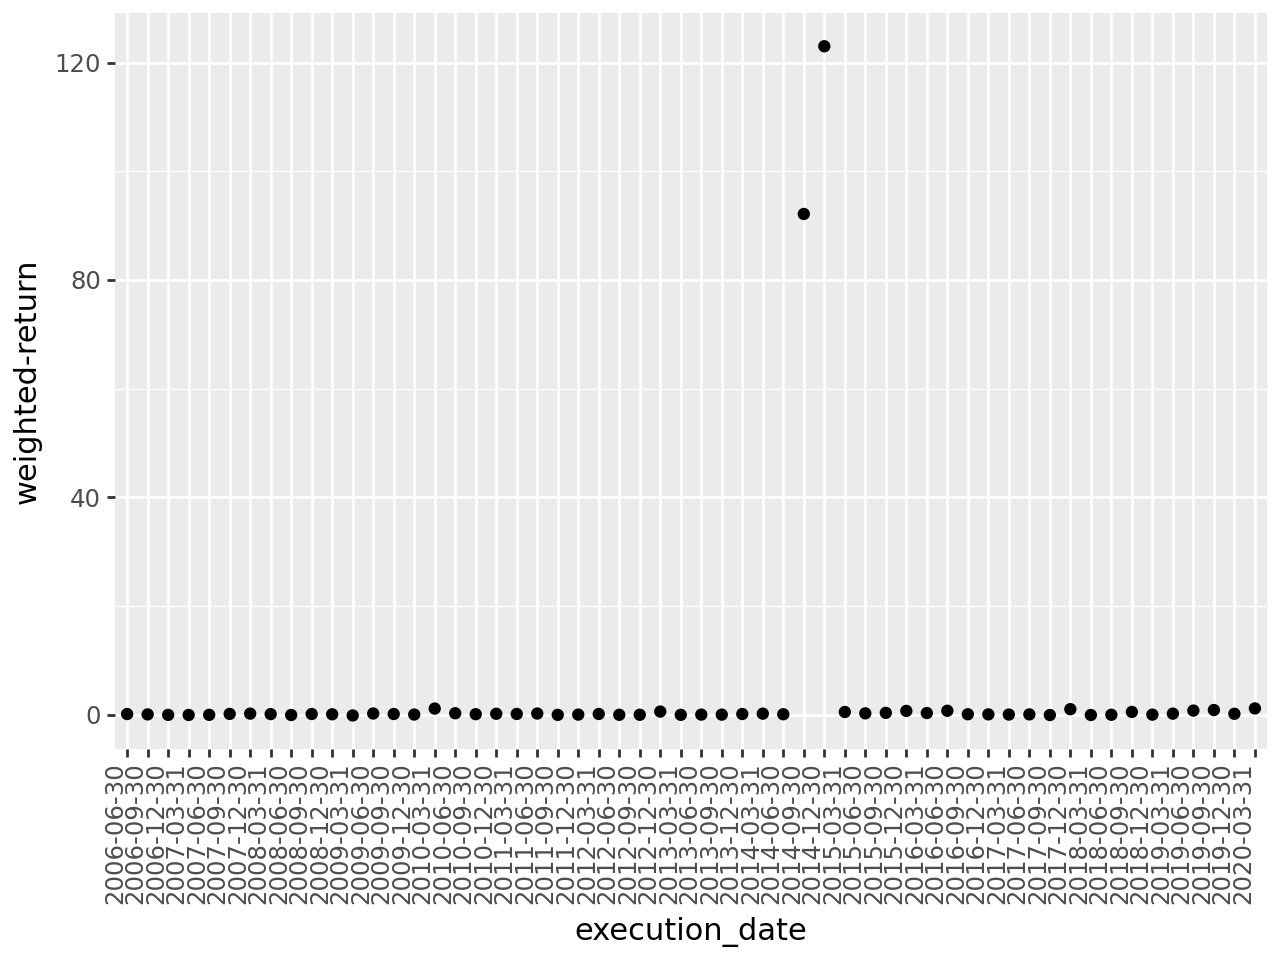

In [51]:
ggplot(test_results_final_tree) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))

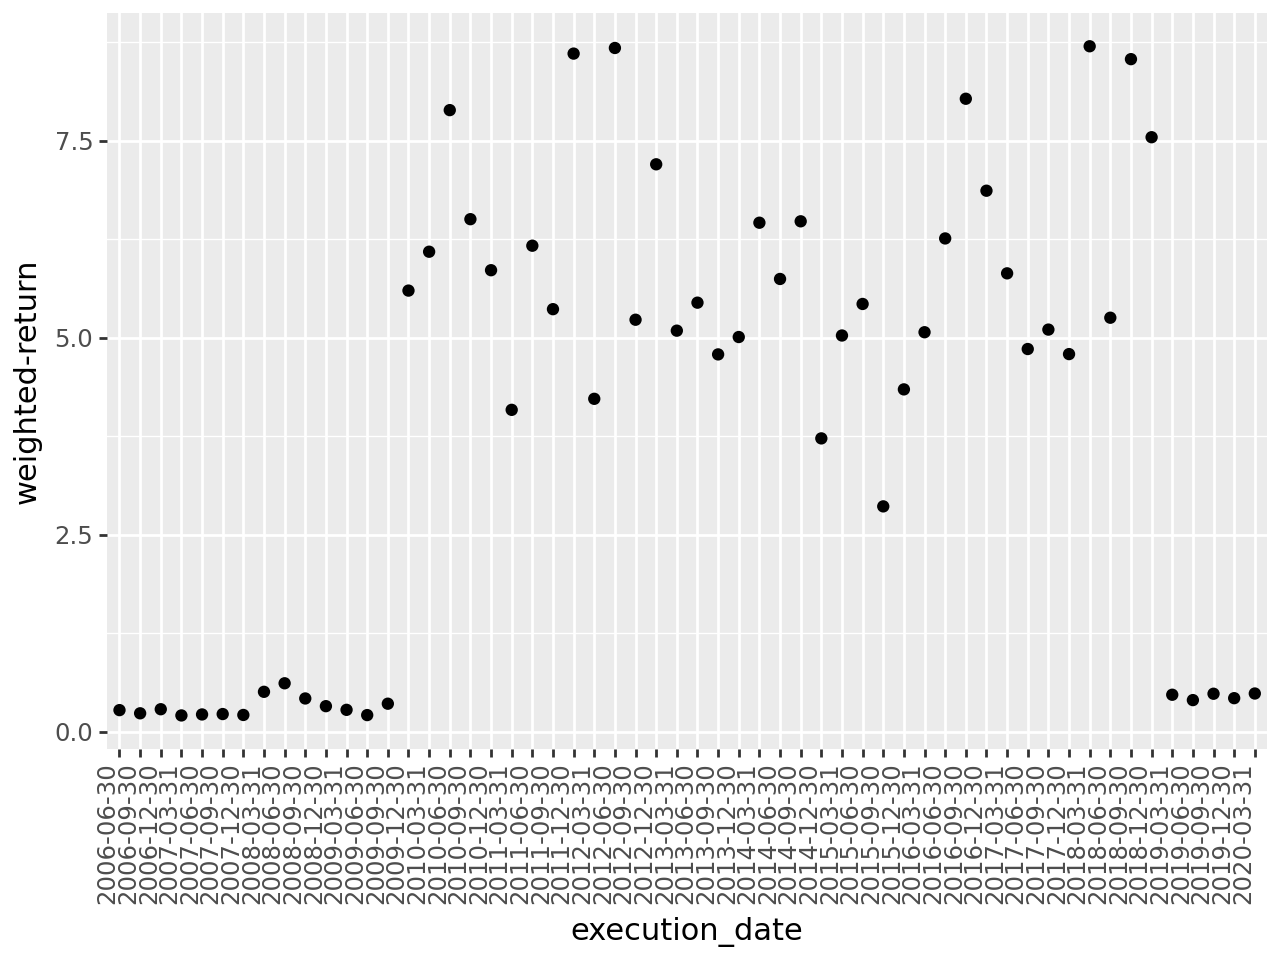

In [52]:
ggplot(train_results_final_tree) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))

Eliminando la myoría de las variables, el modelo sigue obteniendo los mismos resultados, lo que es indicativo de que el modelo no está usando las variables dadas para realizar la predicción, está usando algún patrón existente en los datos, pero que no ocurre en la realidad. Lo más probable es que el problema del bajo rendimiento del modelo esté en los datos, bien sea porque no son representativos del fenómeno a modelar o porque está actuando algún tipo de sesgo. 

A partir de aquí, se requeriría un cierto nivel de conocimiento de negocio para determinar qué es lo que está pasando realmente. 